<a href="https://colab.research.google.com/github/ywang1110/NLP/blob/main/Quora_Question_Pairs_Similarity_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://miro.medium.com/max/1440/1*YulfXLgM6rhCtaJHDgPPtQ.png"
 height="200"/>


**Reference**:<br/>https://medium.com/analytics-vidhya/quora-question-pairs-similarity-problem-8e3ae90441f0 <br/>https://github.com/vedanshsharma/Quora-Questions-Pairs-Similarity-Problem

#Import libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


#Import the data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
train_set = pd.read_csv('/content/gdrive/My Drive/NLP project/data/train.csv')[0:500000]
test_set = pd.read_csv('/content/gdrive/My Drive/NLP project/data/test.csv')[0:500000]

In [4]:
train_set.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
350651,350651,376841,55209,What was the most embarrassing moment in your ...,What is the most embarrassing thing you did as...,1
69564,69564,120021,120022,What are off-balance-sheet vehicles?,What are some off balance sheet activities?,0
3300,3300,6542,5314,Is there any possibility to increase height af...,How girls can increase their height after 18 y...,1
234739,234739,345313,345314,Can I join Indian Army if I have a power of -3...,I have a power of -3 in both the eyes and a 6/...,0
53088,53088,93905,93906,Can we call racism against Arabs anti-Semitism?,Is President Obama anti-Semitic?,0


In [5]:
test_set.sample(5)

,test_id,question1,question2
95481,95481,How clothes can I get a Wi-Fi password from an...,How do I hack a Wi-Fi password with an Android?
368898,368898,How is your view of beauty?,How do I view everything with beauty?
113399,113399,Can I run two WhatsApp accounts on a dual prop...,How can we find people difference WhatsApp wit...
187928,187928,"As the rpm of an engine increases, the torque ...",How thought are fuel cells compared to hydroge...
414623,414623,Downvoting cancelling ideas does mean everyone...,"Does the letter of steev jobs,which making rou..."


#EDA

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


##Distribution of data points among output class

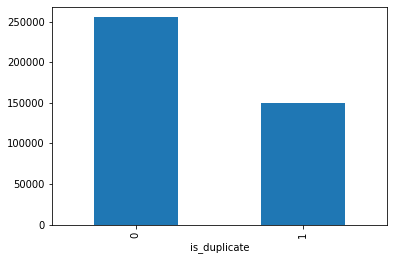

In [7]:
train_set.groupby('is_duplicate')['id'].count().plot(kind='bar')

In [8]:
percentage_noDup = np.mean(train_set['is_duplicate']==0)
percentage_Dup = np.mean(train_set['is_duplicate']==1)

In [9]:
print('Percentage Question pairs that are not duplicate = {:.2f}%'.format(percentage_noDup*100))
print('Percentage Question pairs that are not duplicate = {:.2f}%'.format(percentage_Dup*100))

Percentage Question pairs that are not duplicate = 63.08%
Percentage Question pairs that are not duplicate = 36.92%


##Unique vs. repeated Questions

In [10]:
qids=pd.Series(train_set['qid1'].tolist()+train_set['qid2'].tolist())
qids=qids.value_counts()
qids

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

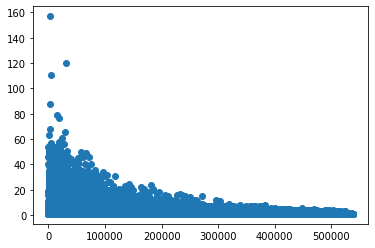

In [11]:
plt.scatter(qids.index, qids)

In [12]:
unique_ids=qids.index
print('Number of unique ids={}'.format(len(unique_ids)))

Number of unique ids=537933


In [13]:
qs_morethan_onetime=np.sum(qids>1)
print('Number of unique questions that appears more than once={}'.format(np.sum(qids>1)))
percentage_morethan_once=np.mean(qids>1)
print('Percentage of unique questions that appears more than once={:.2f}%'.format(percentage_morethan_once*100))

Number of unique questions that appears more than once=111780
Percentage of unique questions that appears more than once=20.78%


In [14]:
qs_max=np.max(qids)
qs_max
print('Max number of times a single question is repeated={}'.format(qs_max))

Max number of times a single question is repeated=157


In [15]:
# check if there are any duplicated pair of questions
pair_duplicates=train_set.groupby(['qid1','qid2'])['id'].count()
pair_duplicates

qid1    qid2  
1       2         1
3       4         1
        282170    1
        380197    1
        488853    1
                 ..
537924  537925    1
537926  537927    1
537928  537929    1
537930  537931    1
537932  537933    1
Name: id, Length: 404290, dtype: int64

In [16]:
if np.sum(pair_duplicates>1)==0:
  print('There is no duplicate pair of questions')

There is no duplicate pair of questions


##Frequency of different questions

In [17]:
qids

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

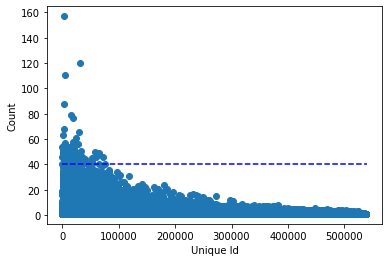

In [18]:
plt.scatter(qids.index, qids)
plt.hlines(y=40, xmax=540000, xmin=0, linestyles='dashed', colors='b')
plt.xlabel('Unique Id')
plt.ylabel('Count')
plt.show()  # msot of questions apprear < 40 times

##Missing values

In [19]:
train_set.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [20]:
train_set[train_set.isnull().any(axis=1)]   # check if 'True' is present in rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [21]:
#Fill an empty space inplace of Null value
train_set=train_set.fillna('')
train_set.isnull().sum(axis=0)

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [22]:
train_set[train_set.isnull().any(axis=1)] # we don't have any Null value in our dataframe

,id,qid1,qid2,question1,question2,is_duplicate


In [23]:
test_set=test_set.fillna('')
test_set[test_set.isnull().any(axis=1)]

,test_id,question1,question2


##Basic Feature Extraction

**New features construction**<br/>

*   **freq_qid1**=Frequency of qid1
*   **freq_qid2**=Frequency of qid2
*   **q1len**=Length of q1 (Characters+space)
*   **q2len**=Length of q2
*   **q1_n_words**=Number of words in Question 1
*   **q2_n_words**=Number of words in Question 2
*   **word_Common**=Number of common words in question 1 and question 2
*   **word_Total**=Total number of word in question 1 and question 2
*   **word_Share**=word_Common/Total_word
*   **freq_q1+freq_q2**=sum total of frequency of qid1 and qid2
*   **freq_q1-freq_q2**=absoulte difference of frequency of qid1 and qid2




In [24]:
train_set.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [25]:
train_set['freq_qid1']=train_set.groupby('qid1')['id'].transform('count')  # pandas.DataFrame.transform -> Call func on self producing a DataFrame with transformed values|same lenght - similar with window function in SQL
train_set['freq_qid2']=train_set.groupby('qid2')['id'].transform('count')  
train_set['q1len']=train_set['question1'].str.len()  # pandas.Series.str.len -> Compute the length of each element in string (characters+spaces)
train_set['q2len']=train_set['question2'].str.len()
train_set['q1_n_words']=train_set['question1'].apply(lambda x: len(str(x).split(' ')))
train_set['q2_n_words']=train_set['question2'].apply(lambda x: len(str(x).split(' ')))

In [26]:
def normalized_word_Common(row):
  w1=set(map(lambda x: x.lower().strip(), str(row['question1']).split(' ')))
  w2=set(map(lambda x: x.lower().strip(), str(row['question2']).split(' ')))
  return 1.0*len(w1 & w2)
train_set['word_Common']=train_set.apply(normalized_word_Common, axis=1)

In [27]:
def normalized_word_Total(row):
  w1=set(map(lambda x: x.lower().strip(), str(row['question1']).split(' ')))
  w2=set(map(lambda x: x.lower().strip(), str(row['question2']).split(' ')))
  return (len(w1)+len(w2))*1.0
train_set['word_Total']=train_set.apply(normalized_word_Total, axis=1)

In [28]:
train_set['word_share']=train_set['word_Common']/train_set['word_Total']
train_set['freq_q1+freq_q2']=train_set['freq_qid1']+train_set['freq_qid2']
train_set['freq_q1-freq_q2']=np.abs(train_set['freq_qid1']-train_set['freq_qid2'])

In [29]:
train_set.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [30]:
train_set.describe()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198,2.827609,3.046961,59.536709,60.108365,10.944592,11.185120,4.511610,21.126112,0.223362,5.874570,1.845715
std,116708.614503,157751.700002,159903.182629,0.482588,4.487418,6.026871,29.940655,33.863870,5.431949,6.311076,3.098656,8.592622,0.128336,9.091068,5.187882
min,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000,1.000000,1.000000,39.000000,39.000000,7.000000,7.000000,2.000000,15.000000,0.125000,2.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000,1.000000,1.000000,52.000000,51.000000,10.000000,10.000000,4.000000,19.000000,0.217391,3.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000,3.000000,2.000000,72.000000,72.000000,13.000000,13.000000,6.000000,25.000000,0.318182,5.000000,2.000000
max,404289.000000,537932.000000,537933.000000,1.000000,50.000000,120.000000,623.000000,1169.000000,125.000000,237.000000,41.000000,166.000000,0.500000,157.000000,119.000000


In [31]:
print('Minimum length of the questions in question1 = {}'.format(np.min(train_set['q1_n_words'])))
print('Minimum length of the questions in question2 = {}'.format(np.min(train_set['q2_n_words'])))
print('Number of questions with minimum length in question1 = {}'.format((train_set['q1_n_words']==1).sum()))
print('Number of questions with minimum length in question2 = {}'.format((train_set['q2_n_words']==1).sum()))

Minimum length of the questions in question1 = 1
Minimum length of the questions in question2 = 1
Number of questions with minimum length in question1 = 67
Number of questions with minimum length in question2 = 24


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


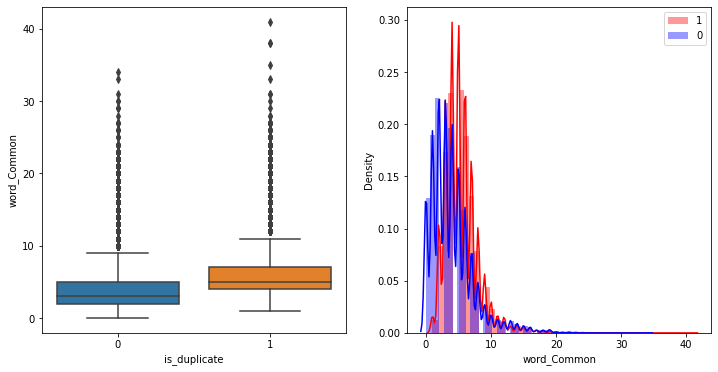

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.boxplot(x = 'is_duplicate', y = 'word_Common', data = train_set)

plt.subplot(1,2,2)
sns.distplot(train_set[train_set['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'red')
sns.distplot(train_set[train_set['is_duplicate'] == 0.0]['word_Common'], label = "0" , color = 'blue' )
plt.legend()
plt.show()



*   The distribution of the word_Common feature in duplicate or non-duplicate pair are highly overlap. Therefore, this feature can not be used for classification



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


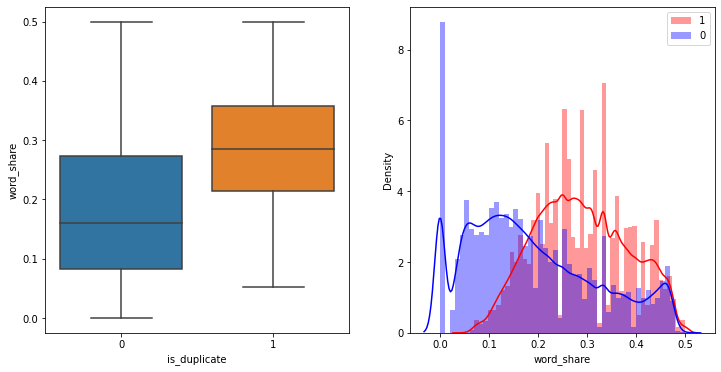

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.boxplot(x = 'is_duplicate', y = 'word_share', data = train_set)

plt.subplot(1,2,2)
sns.distplot(train_set[train_set['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(train_set[train_set['is_duplicate'] == 0.0]['word_share'], label = "0" , color = 'blue' )
plt.legend()
plt.show()



*  The average word share of qid1 and qid2 is more **when they are duplicate**(Similar) 



#Processing of Text (Text normalization)

##Import library

In [34]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [35]:
import nltk
from nltk.corpus import stopwords

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [38]:
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

##preprocessing

###Lowercase

In [39]:
def convert_lower_case(data):
  return np.char.lower(data)

###Removing stop words

In [40]:
def remove_stop_words(data):
  stop_words = stopwords.words('english')
  words = word_tokenize(str(data))
  new_text=""
  for w in words:
    if w not in stop_words and len(w)>1:
      new_text = new_text+" "+w
  return data

###Removing punctuation

In [41]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

###Removing apostrophe

In [42]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

###Stemming

In [43]:
def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

###convert_numbers

In [44]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_tex

In [45]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

##**Advanced Feature Extraction** (NLP and Fuzzy Features)

**Definition:**<br/>


*   **Token:** Get a token by spliting a space
*   **Stop_Word:** Stop word as per NLTK
*   **Word:** A token that is not a stop_word




In [46]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [47]:
# Try

In [48]:
sentences = []
for s in tqdm.tqdm(train_set['question1'].tolist()):
  sentences.append(tokenizer.tokenize(str(s)))

100%|██████████| 404290/404290 [00:02<00:00, 171073.92it/s]


In [49]:
print(train_set['question1'].tolist()[0:2])
print(sentences[0:2])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?']
[['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], ['What', 'is', 'the', 'story', 'of', 'Kohinoor', 'Koh', 'i', 'Noor', 'Diamond']]


In [50]:
def get_words(input_sentences):
  output_sentences = []
  for p in input_sentences:
    output_sentences.append(tokenizer.tokenize(str(p)))
  return output_sentences

In [51]:
train_questions1 = train_set['question1'].tolist()
train_questions1_words = get_words(train_set['question1'])
train_questions2_words = get_words(train_set['question2'])
test_questions1_words = get_words(test_set['question1'])
test_questions2_words = get_words(test_set['question2'])

In [52]:
# Check
print(test_set['question2'].tolist()[0:2])
print(test_questions2_words[0:2])

['Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?', 'How much cost does hair transplant require?']
[['Why', 'did', 'Microsoft', 'choose', 'core', 'm3', 'and', 'not', 'core', 'i3', 'home', 'Surface', 'Pro', '4'], ['How', 'much', 'cost', 'does', 'hair', 'transplant', 'require']]


##TF-IDF (Term Frequency — Inverse Document Frequency)
Compute a weight to each word which signifies the importanace of the word in the document and corpus. <br/>
TF-IDF = Term Frequency (TF)*Inverse Document Frequency (IDF)

---
*  **Term frequency (TF)**: frequency of a word in a document (highly depends on the length of the document and the generality of word) <br/> TF is individually to each document and word<br/> ***tf(t,d) = count of t in d / number of words in d***


*  Why not just use TF?<br/>
1. common words, as well as stop-words (e.g. is am are) will have very high values and give those words a very high importance
2. 

---
*  **Document Frequency:** the number of documents in which the word is present.We consider one occurrence if the term consists in the document at least once, we do not need to know the number of times the term is present.<br/> ***df(t) = occurrence of t in documents***
---
**Inverse Document Frequency**
idf(t) = N/df


*   Large corpus -> IDF explodes <br/>idf(t) = log(N/df)
*   word which is not in vocab <br/>df=0 -> idf(t)=log(N/(df+1))


---
*  t-term (word)
*  d-document(set of words)
*  N-count of corpus
*  corpus-the total document set

**Basis version of IF-IDF score:**<br/>
tf-idf(t,d) = tf(t,d)*log(N/(df+1))




https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089



1.   Vectorize the documents on the vocab (the list of all possible words in the corpus)<br/>





In [53]:
from gensim import corpora
from gensim.models import TfidfModel

In [54]:
train_questions1 = train_set['question1'].tolist()
train_questions2 = train_set['question2'].tolist()
test_questions1 = test_set['question1'].tolist()
test_questions2 = test_set['question2'].tolist()

In [55]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
questions = train_questions1 + train_questions2 + test_questions1 + test_questions2
questions = list(map(str, questions)) # map -> iterator 
len(questions)

1808580

In [56]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
sentences=[]
for p in tqdm.tqdm(questions):
  sentences.append(tokenizer.tokenize(p))

100%|██████████| 1808580/1808580 [00:09<00:00, 189623.92it/s]


In [57]:
print(questions[0:2])
print(sentences[0:2])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?']
[['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], ['What', 'is', 'the', 'story', 'of', 'Kohinoor', 'Koh', 'i', 'Noor', 'Diamond']]


In [58]:
dictionary = corpora.Dictionary(sentences) # implements the concept of a Dictionary – a mapping between words and their integer ids.

In [59]:
new_corpus = [dictionary.doc2bow(txt) for txt in sentences] # Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.
# Convert corpus to BoW format

In [60]:
tfidf=TfidfModel(new_corpus) # implements functionality related to the TF-IDF              # fit model

In [61]:
tfidf[dictionary.doc2bow(['what', 'is', 'this'])] # (token_id, token_count) 

[(6, 0.24543834432587414), (62, 0.6548946086289305), (899, 0.7147538532413333)]

In [62]:
def get_sentences_tfidfs(input_sentences):
  output_vectors = []
  for p in input_sentences:
    result = tfidf[dictionary.doc2bow(p)]
    output_vectors.append(result)
  return output_vectors

In [63]:
train_questions1_tfidfs = get_sentences_tfidfs(train_questions1_words)

In [64]:
train_questions2_tfidfs = get_sentences_tfidfs(train_questions2_words)

In [65]:
test_questions1_tfidfs = get_sentences_tfidfs(test_questions1_words)
test_questions2_tfidfs = get_sentences_tfidfs(test_questions2_words)

In [66]:
print(train_questions2_words[0])
print(train_questions2_tfidfs[0])

['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market']
[(0, 0.04933443178164834), (1, 0.19284753228440268), (2, 0.4012820777159717), (3, 0.07473018705834851), (5, 0.3042921938461818), (6, 0.06862665301590684), (7, 0.28692343787055236), (8, 0.3177926004253617), (9, 0.7105924904624032), (10, 0.05043536076045174), (11, 0.07522014648828668)]


In [67]:
dictionary[1]

'by'

##Word2Vec
The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling
* Skip-gram: word -> words in a window
* CBOW: words (windows) -> word<br/>

output: vector/embedding of words

In [68]:
from gensim.models import Word2Vec

In [69]:
sentences = sentences[0:10000]  # reduce sample size

In [70]:
word2vec = Word2Vec(sentences=sentences, size=50, window=8, iter=10, min_count=1)

In [71]:
print('person vs man: ', word2vec.wv.similarity('person', 'man'))
print('ocean vs sea : ', word2vec.wv.similarity('ocean', 'sea'))b

person vs man:  0.9894151
ocean vs sea :  0.98334086


In [79]:
word2vec.wv.vocab['man'].count

28

In [81]:
len(word2vec.wv.vocab)

13247

###Word vector ---> sentence vector

* Direct Merge: Max, Average, `[w1,w2, w3, ...., wn]`  `w1 100-d vector`

* TF-IDF: weighted sum

* Deep Learning: embeddings, `[f1, f2,...,fn]` (f --> feature) (LSTM, GRU, Attention)

    - Last Output: fn
    - Hidden Vector (LSTM, GRU), hn
    - Attention: `[aw1, aw2, .... ,awn]`  (attention weights), weighted sum -> sentence vector

## Word2Vector or GloVe？

* Our data (-)
* Public Corups (general, training budget)
* Load models, twitter.27B

* Huge dataset: training by yourself
* small dataset: public models
* normal dataset： load public models ---> update model 

`embedding layer` ---> load weights & fine-tuning (classification/translation)


> Indented block



### Load word vectors from pretrained

use `gensim.models.KeyedVectors`

download the model first, such as `glove.6B.100d.txt` from https://nlp.stanford.edu/projects/glove/

In [72]:
from gensim.models import KeyedVectors

In [73]:
glove_vector_path = '/content/gdrive/My Drive/NLP project/data/glove.twitter.27B.100d.txt'

####convert glove style to gensim style
Glove txts have different styles from gensim. You need convert the styles of glove txts for usage

In [74]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

In [75]:
glove_file = datapath(glove_vector_path)
tmp_file = get_tmpfile("converted_glove.txt")

In [76]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [77]:
_ = glove2word2vec(glove_file, tmp_file)

FileNotFoundError: ignored